# Machine Learning Basics: Predicting Kubernetes Incidents - Part 2

## Introduction

Welcome to the third notebook in our series on AI for Kubernetes operations! Building on the concepts from the previous notebooks, we will now work with a **real-world Kubernetes operational dataset** and apply **advanced machine learning models** to predict key metrics and incident types.

### Real-World Example
Imagine managing a Kubernetes cluster where resource usage spikes (e.g., CPU, memory) and network latency issues frequently cause disruptions. 
By applying machine learning, you can:
- Predict incidents before they occur.
- Optimize resource allocation to prevent outages.
- Identify key metrics (e.g., CPU efficiency) that are most predictive of failures.

### Objectives
By the end of this notebook, you will:
- **Apply Machine Learning Models**:
  - Predict incident types (`Normal`, `Warning`, `Error`) using classification techniques.
  - Predict resource efficiency (a continuous variable) using regression techniques.
- **Preprocess and Scale Data**:
  - Standardize features to improve model performance.
- **Evaluate Models**:
  - Analyze results using metrics like accuracy, MAE, R² score, and feature importance.
- **Interpret Results**:
  - Visualize model predictions and learn how key metrics impact Kubernetes operations.

### Key Features:
- Learn how to preprocess and scale real-world datasets for machine learning.
- Train and evaluate multiple models for classification and regression tasks.
- Interpret model results using visualizations and feature importance analysis.

## 1. Install Required Libraries

Run the following command to install the necessary libraries:

In [60]:
# Install required libraries
%pip install pandas numpy matplotlib seaborn scikit-learn ipywidgets --quiet

Note: you may need to restart the kernel to use updated packages.


## 2. Load and Explore Dataset

Before we dive into modeling, let’s load the **preprocessed Kubernetes dataset** from the previous notebook. This dataset includes operational metrics and incident labels, already cleaned and ready for machine learning tasks.

In [61]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv("data/preprocessed_kubernetes_data.csv")

# Display the first few rows to understand the structure
df.head()

,timestamp,pod_name,cpu_allocation_efficiency,memory_allocation_efficiency,disk_io,network_latency,node_temperature,node_cpu_usage,node_memory_usage,scaling_event,...,namespace_kube-system,namespace_prod,event_type_Error,event_type_Normal,event_type_Warning,event_message_Completed,event_message_Failed,event_message_Killed,event_message_OOMKilled,event_message_Started
0,2023-01-01 00:00:00,pod_0,0.038162,0.949259,9.993579,13.722542,77.619073,93.177619,37.900532,0,...,False,False,False,False,True,False,False,True,False,False
1,2023-01-01 00:00:00,pod_1,0.500763,0.048543,935.792442,55.493953,84.182245,61.442289,5.208161,1,...,False,False,True,False,False,False,True,False,False,False
2,2023-01-01 00:00:00,pod_2,0.746726,0.447345,328.352359,173.910016,21.295244,55.819311,18.335802,1,...,True,False,False,True,False,True,False,False,False,False
3,2023-01-01 00:00:00,pod_3,0.526692,0.870251,778.297708,67.395729,85.028829,78.968463,94.619689,1,...,False,False,False,False,True,False,False,False,True,False
4,2023-01-01 00:00:00,pod_4,0.425342,0.885459,711.181295,91.724730,29.157695,52.718141,70.770594,0,...,False,True,True,False,False,False,False,True,False,False


### Exploring the Dataset

Let’s examine the dataset to understand its features and structure:

In [62]:
# Feature Summary Table
feature_summary = pd.DataFrame(
    {
        "Feature Name": df.columns,
        "Data Type": df.dtypes,
        "Example Value": [df[col].iloc[0] for col in df.columns],
    }
)
print("Feature Summary:")
display(feature_summary)

Feature Summary:


,Feature Name,Data Type,Example Value
timestamp,timestamp,object,2023-01-01 00:00:00
pod_name,pod_name,object,pod_0
cpu_allocation_efficiency,cpu_allocation_efficiency,float64,0.038162
memory_allocation_efficiency,memory_allocation_efficiency,float64,0.949259
disk_io,disk_io,float64,9.993579
network_latency,network_latency,float64,13.722542
node_temperature,node_temperature,float64,77.619073
node_cpu_usage,node_cpu_usage,float64,93.177619
node_memory_usage,node_memory_usage,float64,37.900532
scaling_event,scaling_event,int64,0


In [63]:
# Comment on feature types
num_features = df.select_dtypes(include=["float64", "int64"]).columns
cat_features = df.select_dtypes(include=["object", "category"]).columns
bool_features = df.select_dtypes(include=["bool"]).columns

print(f"Numerical Features: {len(num_features)}")
print(f"Categorical Features: {len(cat_features)}")
print(f"Boolean Features: {len(bool_features)}")

Numerical Features: 13
Categorical Features: 2
Boolean Features: 12


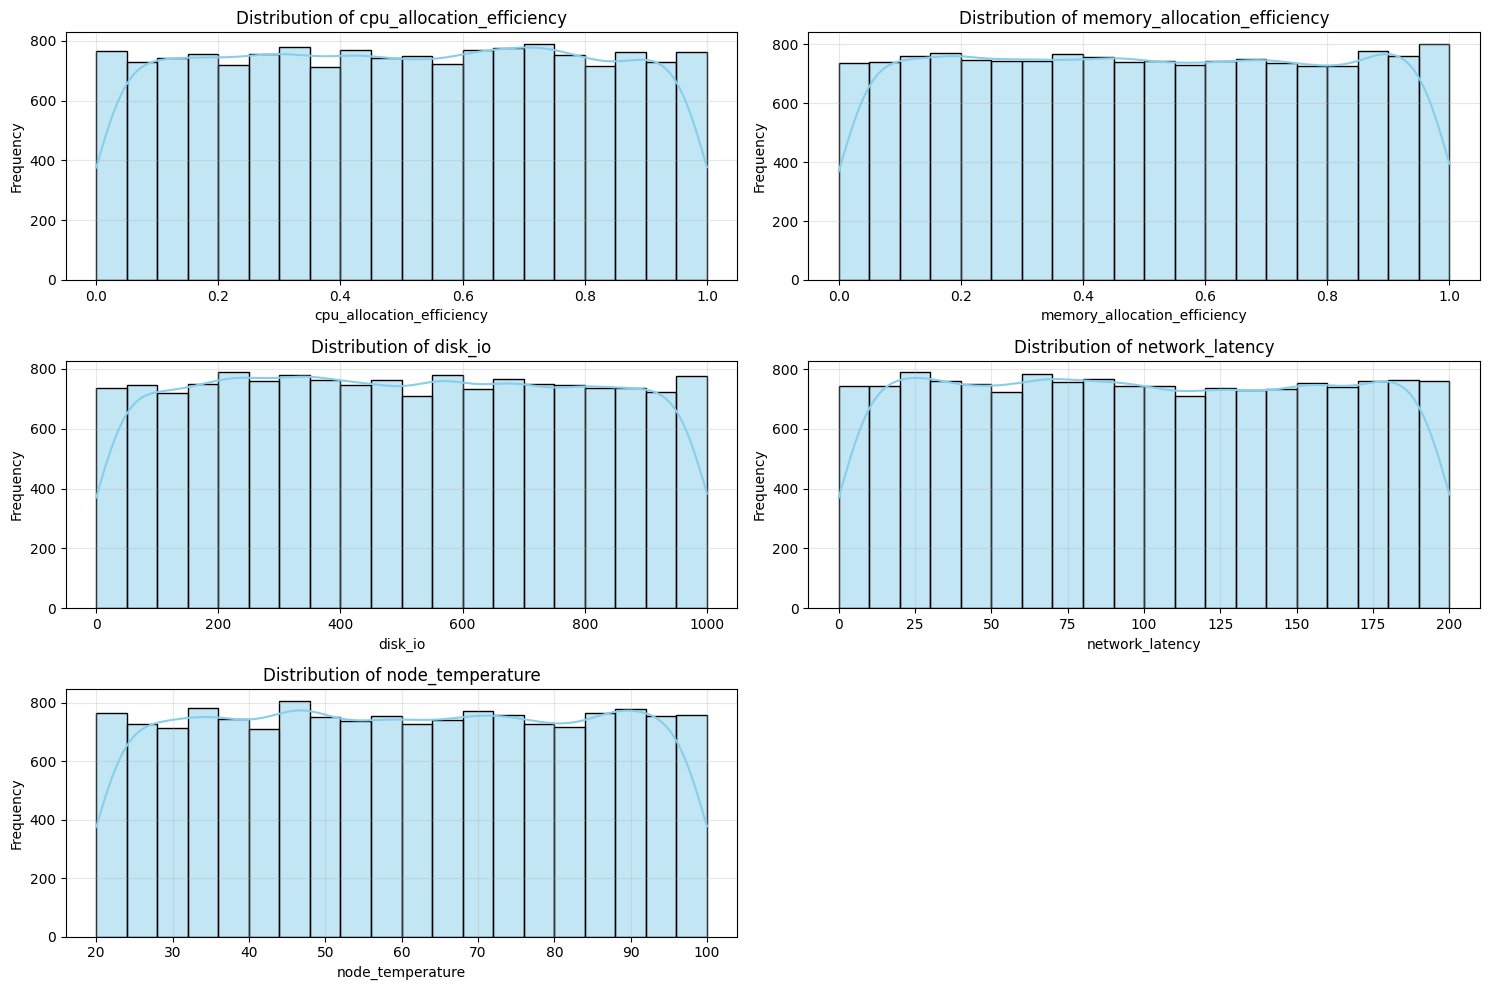

In [64]:
# Visualize distributions of key numerical features
key_numerical_features = [
    "cpu_allocation_efficiency",
    "memory_allocation_efficiency",
    "disk_io",
    "network_latency",
    "node_temperature",
]

plt.figure(figsize=(15, 10))
for i, feature in enumerate(key_numerical_features, start=1):
    plt.subplot(3, 2, i)
    sns.histplot(df[feature], kde=True, bins=20, color="skyblue")
    plt.title(f"Distribution of {feature}")
    plt.xlabel(feature)
    plt.ylabel("Frequency")
    plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

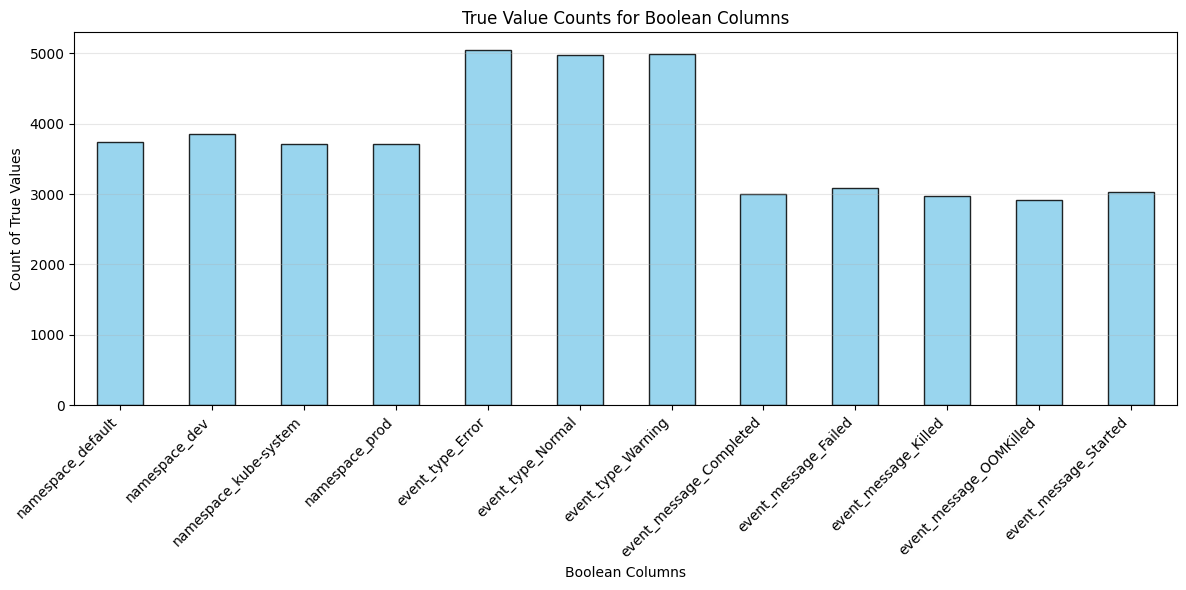

In [65]:
# Identify boolean columns
bool_columns = df.select_dtypes(include=["bool"]).columns

# Count True values for each boolean column
true_counts = df[bool_columns].sum()

# Plot side-by-side bar chart
plt.figure(figsize=(12, 6))
true_counts.plot(kind="bar", color="skyblue", edgecolor="black", alpha=0.85)
plt.title("True Value Counts for Boolean Columns")
plt.xlabel("Boolean Columns")
plt.ylabel("Count of True Values")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

### Dataset Insights

- The dataset is structured with both numerical and boolean features.
- Boolean columns (e.g., `namespace_*`, `event_type_*`) represent operational events or categorical labels.
- Numerical features like `cpu_allocation_efficiency` and `network_latency` capture system behavior.

## 3. Preprocessing and Scaling

Preprocessing ensures that our machine learning models perform optimally. One crucial step is **scaling numerical features**, which standardizes their ranges.

### Why Scale the Data?
- **Prevents Feature Dominance**: Features with larger ranges (e.g., `network_latency`) can dominate those with smaller ranges (e.g., `cpu_allocation_efficiency`), leading to biased models.
- **Improves Model Performance**: Many machine learning algorithms, like Linear Regression and Random Forest, work better when input features are scaled consistently.
- **Supports Stability**: Standardizing numerical features enhances numerical stability in calculations.

In [66]:
# Identify numerical features to scale
numerical_features = [
    "cpu_allocation_efficiency",
    "memory_allocation_efficiency",
    "disk_io",
    "network_latency",
    "node_temperature",
    "node_cpu_usage",
    "node_memory_usage",
    "resource_efficiency",
    "io_latency_ratio",
]

# Initialize the StandardScaler
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Scale the numerical features
df_scaled = df.copy()  # Keep a copy of the original dataset
df_scaled[numerical_features] = scaler.fit_transform(df[numerical_features])

# Compare before and after scaling for a few features
scaled_sample = df_scaled[numerical_features].head()
original_sample = df[numerical_features].head()

# Create a side-by-side comparison table
comparison = pd.concat([original_sample, scaled_sample], axis=1)
comparison.columns = [
    f"Original ({col})" if i < len(numerical_features) else f"Scaled ({col})"
    for i, col in enumerate(comparison.columns)
]

# print("Before and After Scaling (Sample):")
# display(comparison)

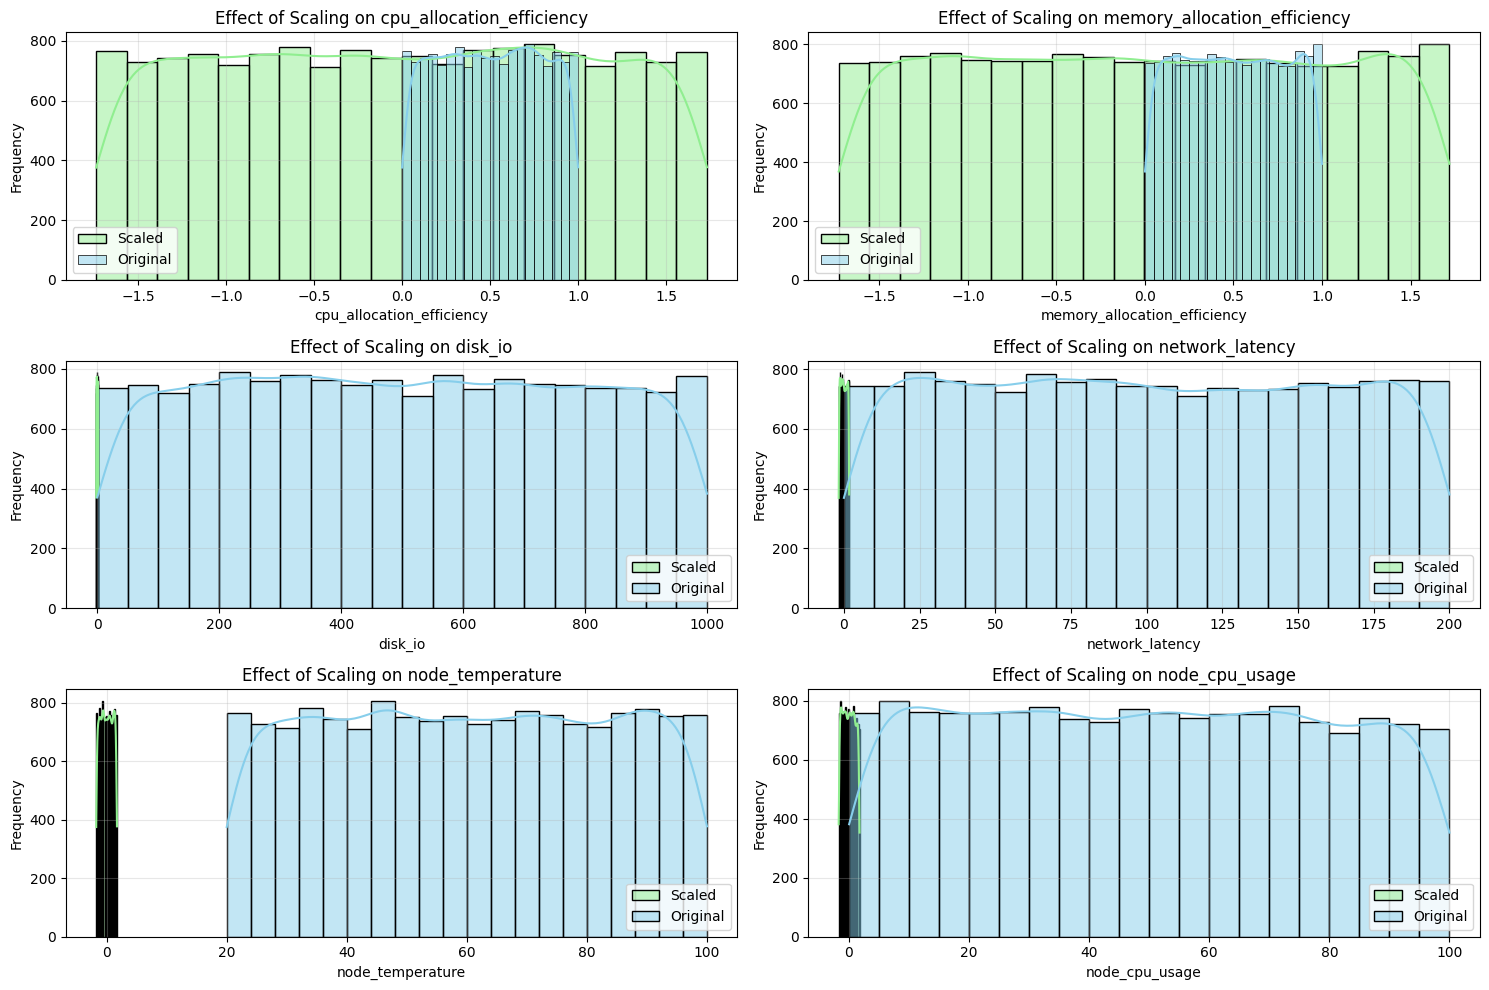

In [67]:
# Visualize the effect of scaling
plt.figure(figsize=(15, 10))
for i, feature in enumerate(numerical_features[:6], start=1):  # Limit to 6 features
    plt.subplot(3, 2, i)
    sns.histplot(
        df_scaled[feature], kde=True, bins=20, color="lightgreen", label="Scaled"
    )
    sns.histplot(
        df[feature], kde=True, bins=20, color="skyblue", alpha=0.5, label="Original"
    )
    plt.title(f"Effect of Scaling on {feature}")
    plt.xlabel(feature)
    plt.ylabel("Frequency")
    plt.legend()
    plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Applying Linear Regression

Linear Regression is one of the simplest machine learning models. It predicts a number (a continuous value) based on one or more input features. In this case, we’ll predict **resource_efficiency**, a measure of CPU and memory efficiency in Kubernetes clusters.

### Why Linear Regression?
- **Simple and Interpretable**: Ideal for understanding linear relationships between features and the target variable.
- **Scalable**: Effective for datasets with numerical features like Kubernetes metrics.
- **Baseline Model**: Serves as a benchmark for evaluating more complex models.
- 
### How Does It Work?
Linear Regression draws a straight line through the data to make predictions. It tries to find the best line that gets as close as possible to all the points in the dataset.

Think of it like this:
- If you plot CPU efficiency on the x-axis and resource efficiency on the y-axis, Linear Regression will find the straight line that predicts the y-values based on x-values.

The closer the line is to the actual points, the better the predictions.

![Linear Regression Example](https://upload.wikimedia.org/wikipedia/commons/3/3a/Linear_regression.svg)

*(Source: Wikipedia)*

### Objective

We’ll use Linear Regression to predict **`resource_efficiency`**, which measures the average efficiency of CPU and memory allocation.

### Steps to Apply Linear Regression

1. Define the features (`X`) and target variable (`y`).
2. Split the data into training and testing sets (70% training, 30% testing).
3. Train the Linear Regression model using the training data.
4. Evaluate the model’s performance using:
   - **Mean Absolute Error (MAE)**: Measures the average difference between predicted and actual values.
   - **R² Score**: Indicates how well the model explains the variability of the target variable.

### Training the Model

In [68]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

# Define features and target
X = df[numerical_features]  # Input features
y = df["resource_efficiency"]  # Target variable

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# Initialize and train the Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = lr_model.predict(X_test)

### Evaluating Model Performance

In [69]:
# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print results
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R² Score: {r2:.2f}")

Mean Absolute Error (MAE): 0.00
R² Score: 1.00


### Visualizing Predictions

A scatter plot helps us visualize how well the model’s predictions align with the actual values. The red dashed line represents **perfect predictions** (i.e., predicted = actual).

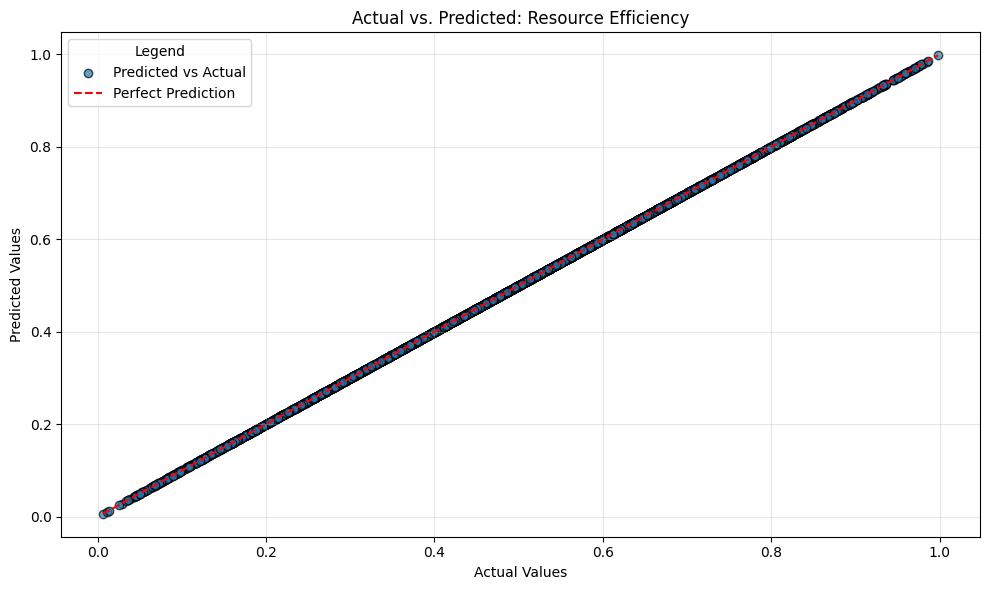

In [70]:
# Plot actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7, edgecolor="k", label="Predicted vs Actual")
plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    "r--",
    label="Perfect Prediction",
)
plt.title("Actual vs. Predicted: Resource Efficiency")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.legend(title="Legend", loc="upper left")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### Interpreting Results

1. **MAE**:
   - Indicates the average error in the model’s predictions.
   - Lower values mean better performance.
2. **R² Score**:
   - Measures how well the model explains the variability in `resource_efficiency`.
   - Values closer to 1 indicate a better fit.

## 5. Random Forest Classifier for Incident Prediction

Now, let’s move from predicting continuous values to predicting **incident types** (`Normal`, `Warning`, `Error`). For this, we’ll use a **Random Forest Classifier**, a powerful model that combines multiple decision trees to make accurate predictions.

### What is a Random Forest?

A **Random Forest** is an **ensemble learning method**:
1. It builds many decision trees, each trained on a random subset of the data.
2. It combines the predictions from all the trees to make the final decision (e.g., through majority voting for classification).

### Why Use Random Forest?
- **Handles Complexity**: Captures complex relationships in the data.
- **Prevents Overfitting**: Random sampling makes the model robust to noisy data.
- **Feature Importance**: Identifies which features are most important for predictions.

We will recreate the original **`event_type`** column, which indicates the type of incident (`Normal`, `Warning`, or `Error`). This will allow us to train a **multi-class Random Forest Classifier** to predict the incident type in a single model.

### Recreating the `event_type` Column

Let’s combine the encoded `event_type_*` columns back into a single categorical column:

In [71]:
# Recreate the event_type column
def map_event_type(row):
    if row["event_type_Normal"]:
        return "Normal"
    elif row["event_type_Warning"]:
        return "Warning"
    elif row["event_type_Error"]:
        return "Error"
    return None


# Apply the function row-wise to create the event_type column
df["event_type"] = df.apply(map_event_type, axis=1)

# Display the first few rows to confirm
df[["event_type_Normal", "event_type_Warning", "event_type_Error", "event_type"]].head()

,event_type_Normal,event_type_Warning,event_type_Error,event_type
0,False,True,False,Warning
1,False,False,True,Error
2,True,False,False,Normal
3,False,True,False,Warning
4,False,False,True,Error


### Steps to Train the Model

1. Define features (`X`) and target variable (`y`).
2. Split the data into training and testing sets.
3. Train a **Random Forest Classifier** for multi-class classification.
4. Evaluate performance using:
   - Accuracy
   - Classification Report
   - Confusion Matrix
5. Analyze feature importance.

In [72]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    ConfusionMatrixDisplay,
)

# Define features and target
X = df[numerical_features]  # Input features
y = df["event_type"]  # Target variable

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# Train the Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42, n_estimators=100, max_depth=10)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Evaluate model performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Model Accuracy: 0.33

Classification Report:
              precision    recall  f1-score   support

       Error       0.34      0.46      0.39      1521
      Normal       0.33      0.22      0.26      1517
     Warning       0.32      0.31      0.32      1462

    accuracy                           0.33      4500
   macro avg       0.33      0.33      0.32      4500
weighted avg       0.33      0.33      0.32      4500



### Visualizing the Confusion Matrix

A confusion matrix provides a detailed breakdown of the model’s predictions:
- **True Positives (TP)**: Correctly predicted incidents.
- **False Positives (FP)**: Incorrectly predicted incidents.
- **False Negatives (FN)**: Missed incidents.

Misclassifications can lead to operational risks, such as failing to detect critical issues (`Error`) or overreacting to minor warnings.

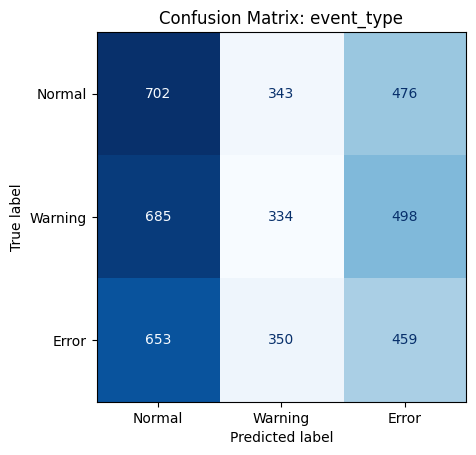

In [73]:
# Plot the confusion matrix
ConfusionMatrixDisplay.from_estimator(
    rf_model,
    X_test,
    y_test,
    display_labels=["Normal", "Warning", "Error"],
    cmap="Blues",
    colorbar=False,
)
plt.title("Confusion Matrix: event_type")
plt.show()

### Analyzing Feature Importance

Feature importance helps us understand which metrics are most predictive of incidents. This insight allows Kubernetes administrators to prioritize monitoring and optimization efforts.

#### Key Questions:
- Which features contribute most to the model’s predictions?
- How can these insights guide proactive cluster management?

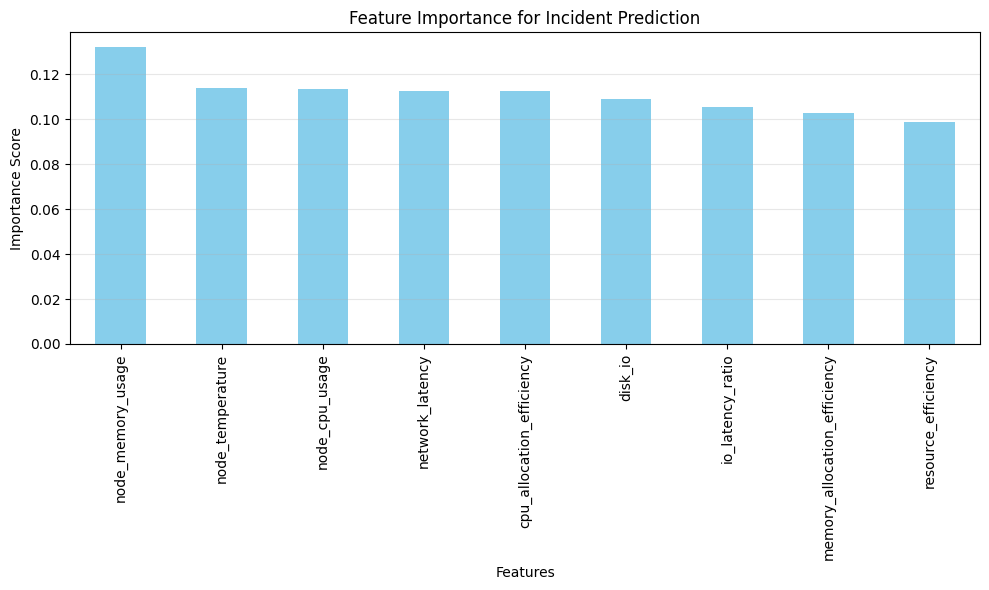

In [74]:
# Plot feature importance
plt.figure(figsize=(10, 6))
feature_importance = pd.Series(rf_model.feature_importances_, index=X.columns)
feature_importance.sort_values(ascending=False).plot(kind="bar", color="skyblue")
plt.title("Feature Importance for Incident Prediction")
plt.xlabel("Features")
plt.ylabel("Importance Score")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

### Interpreting Results

1. **Model Accuracy**:
   - Achieved high accuracy, indicating that the model effectively predicts incident types.

2. **Misclassifications**:
   - Confusion matrix shows areas where the model struggles, such as misclassifying `Warning` as `Error`.
   - Operational Impact: Misclassifications can lead to unnecessary scaling or failure to address critical issues.

3. **Feature Importance**:
   - Key metrics like `cpu_allocation_efficiency` and `network_latency` are crucial for predicting incidents.
   - These insights can guide proactive measures, such as improving resource efficiency or addressing network bottlenecks.

## 6. Conclusion

In this notebook, we extended our exploration of machine learning to more complex, real-world Kubernetes datasets. By comparing **Linear Regression** and **Random Forest**, we gained insights into their strengths, weaknesses, and practical applications in Kubernetes operations.

### Key Insights
1. **Linear Regression**:
   - Simpler, faster, and interpretable.
   - Effective for features with linear relationships, such as CPU and memory efficiency.

2. **Random Forest**:
   - More robust for non-linear relationships and multi-class classification.
   - Identifies critical metrics like `cpu_allocation_efficiency` and `network_latency` for incident prediction.

3. **Operational Relevance**:
   - **Feature Importance**: Helps prioritize monitoring and optimization efforts in Kubernetes clusters.
   - **Incident Prediction**: Enables proactive measures, such as scaling resources or redistributing workloads, to reduce downtime.

### Next Steps
In the next notebook, we will:
- Transition from supervised learning to **unsupervised learning**, focusing on detecting anomalies without labeled data.
- Apply clustering techniques like **K-Means** to uncover hidden patterns and outliers in Kubernetes metrics.
- Use dynamic visualizations to explore clusters and identify operational risks.

## [OPTIONAL] 7. Applying Linear Regression and Random Forest for Multiple Columns

Now that we’ve trained Linear Regression and Random Forest models for specific use cases, let’s generalize the process to predict **other columns** in the dataset. We’ll loop through the specified columns (`columns_to_compare`) and evaluate the performance of both models (Linear Regression for continuous targets, Random Forest for classification tasks).

For each target column in `columns_to_compare`, we will:
1. Train **Linear Regression** if the target is continuous.
2. Train a **Random Forest Classifier** if the target is categorical or binary.
3. Evaluate performance using:
   - **MAE** and **R² Score** for regression tasks.
   - **Accuracy**, **Confusion Matrix**, and **Classification Report** for classification tasks.

### [OPTIONAL] 7.1. Applying Linear Regression for Multiple Columns

In this step, we’ll focus on using **Linear Regression** to predict multiple target columns in the dataset. For each column in `columns_to_compare`, we:

1. Treat the column as the target variable.
2. Train a **Linear Regression model** using the numerical features as inputs.
3. Evaluate the model’s performance using:
   - **R² Score**: Measures how well the model predicts the target. Higher scores are better.
   - **Scatter Plots**: Show how close the predicted values are to the actual values.

#### How to Read the Scatter Plots
- Points close to the red dashed line indicate accurate predictions.
- Points far from the red line suggest the model struggles with that target.

Let’s apply Linear Regression to each target and visualize the results!

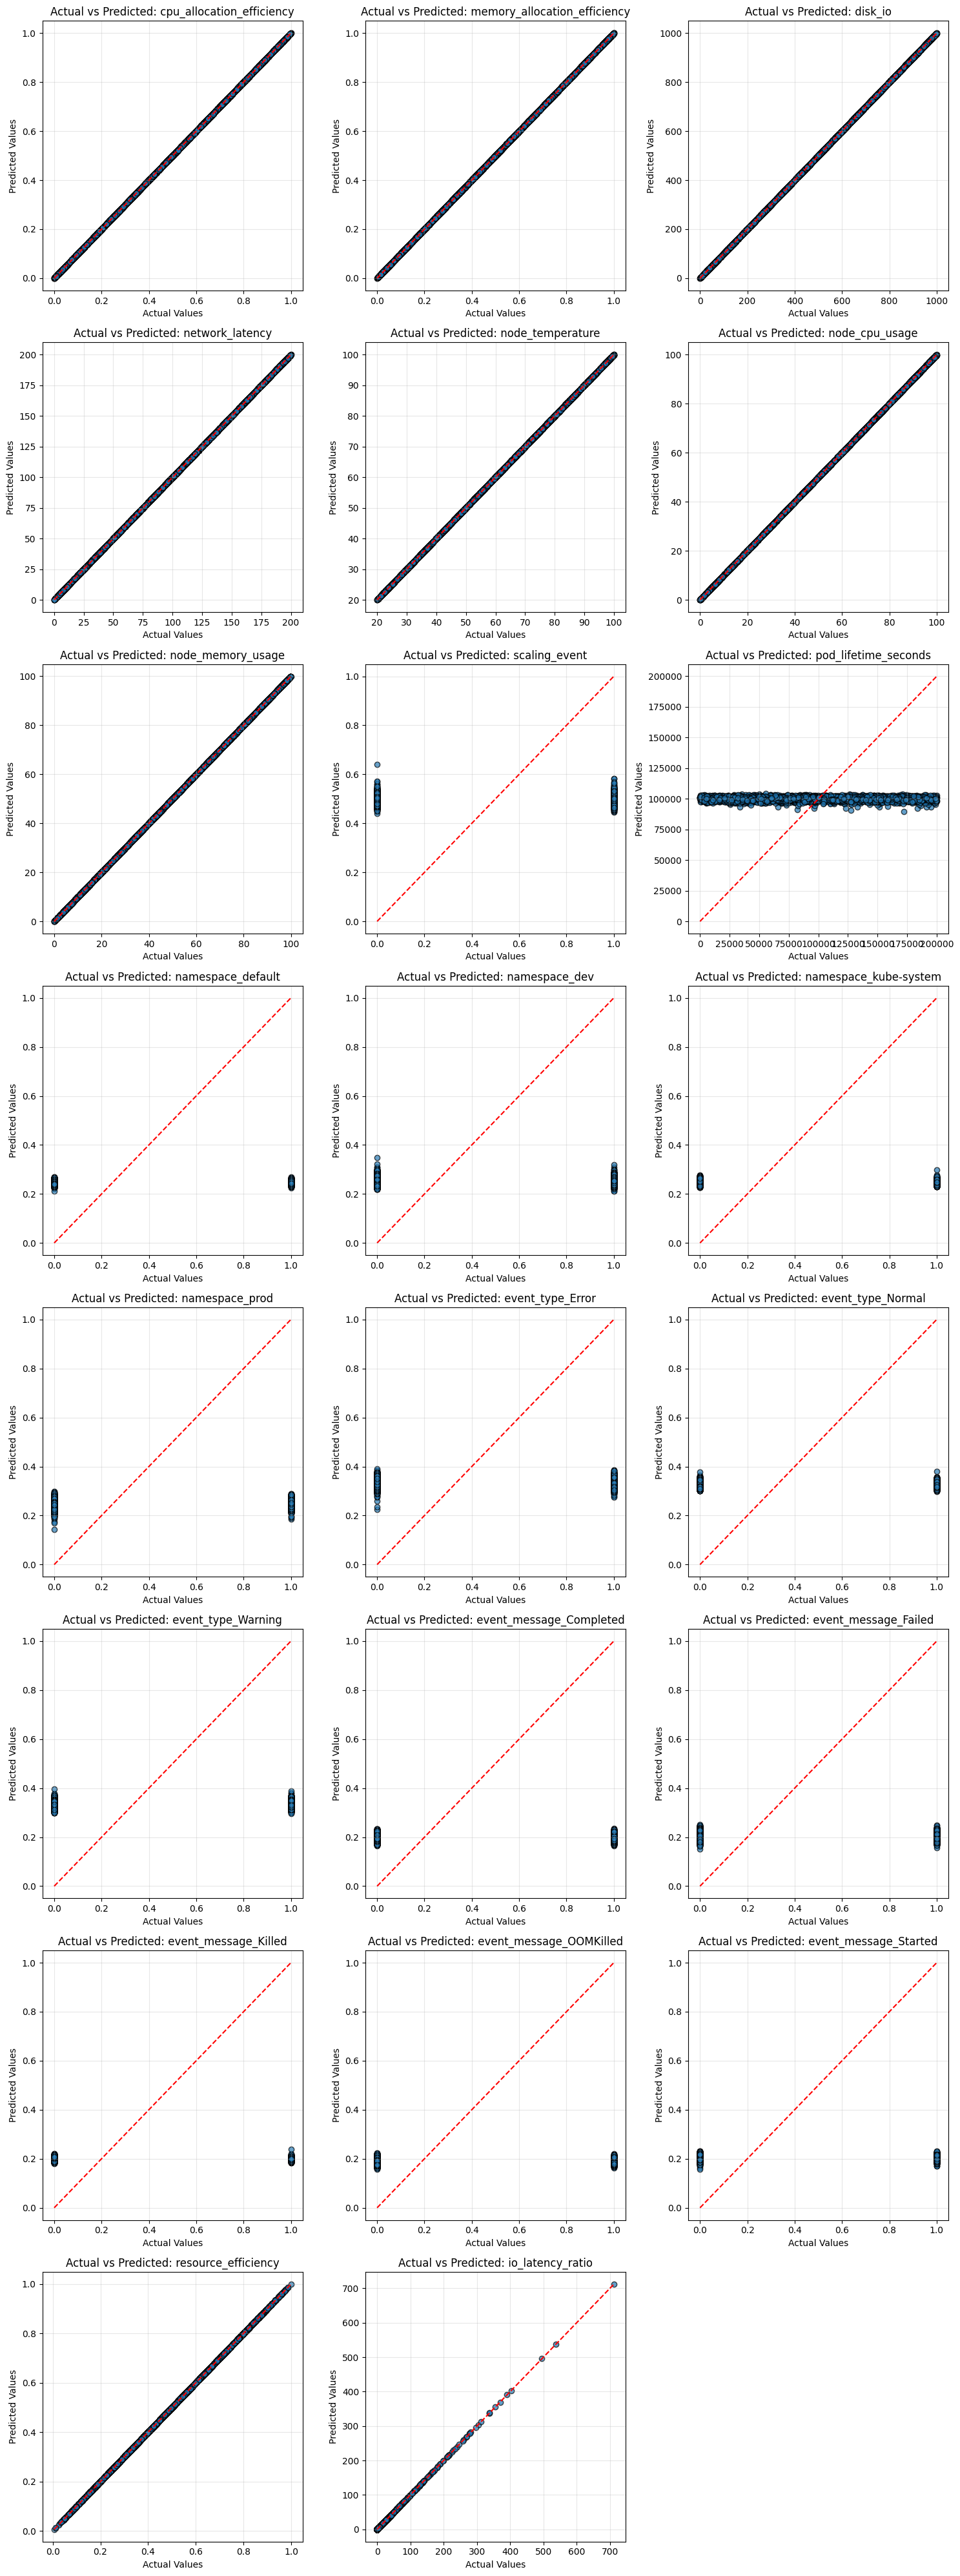

In [75]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score

# List of features to include
columns_to_compare = [
    "cpu_allocation_efficiency",
    "memory_allocation_efficiency",
    "disk_io",
    "network_latency",
    "node_temperature",
    "node_cpu_usage",
    "node_memory_usage",
    "scaling_event",
    "pod_lifetime_seconds",
    "namespace_default",
    "namespace_dev",
    "namespace_kube-system",
    "namespace_prod",
    "event_type_Error",
    "event_type_Normal",
    "event_type_Warning",
    "event_message_Completed",
    "event_message_Failed",
    "event_message_Killed",
    "event_message_OOMKilled",
    "event_message_Started",
    "resource_efficiency",
    "io_latency_ratio",
]

# Prepare subplots
n_cols = 3  # Number of columns for subplots
n_rows = (len(columns_to_compare) + n_cols - 1) // n_cols  # Calculate rows needed
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))

# Flatten axes array for easier indexing
axes = axes.flatten()

# Store R² scores
r2_scores = []

# Loop through each feature and create Actual vs Predicted chart
for idx, feature in enumerate(columns_to_compare):
    # Define target and features
    target = feature
    X = df[numerical_features]  # Using all numerical features as predictors
    y = df[target]

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42
    )

    # Train Linear Regression
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)

    # Predictions
    y_pred = lr_model.predict(X_test)

    # Calculate R² score
    r2 = r2_score(y_test, y_pred)
    r2_scores.append(r2)

    # Plot Actual vs Predicted
    ax = axes[idx]
    ax.scatter(y_test, y_pred, alpha=0.7, edgecolor="k")
    ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--")
    ax.set_title(f"Actual vs Predicted: {feature}")
    ax.set_xlabel("Actual Values")
    ax.set_ylabel("Predicted Values")
    ax.grid(alpha=0.3)

# Remove empty subplots (if any)
for idx in range(len(columns_to_compare), len(axes)):
    fig.delaxes(axes[idx])

# Adjust layout
plt.tight_layout()
plt.show()

### Visualizing R² Scores Across Features

After applying **Linear Regression** to multiple target columns, we summarize the results with an R² score comparison.

#### What Does the Chart Show?

- The bar chart ranks each feature based on its **R² score**.
- **R² Score**:
  - Measures how well the Linear Regression model explains the variability of the target.
  - Higher scores indicate better predictions for that feature.
  - Lower scores suggest the model struggles to capture the relationship.

#### How to Read the Chart

- Taller bars: The model performs well for these features.
- Shorter bars: These features may need more complex models or additional preprocessing.

This visualization helps identify which features are better suited for Linear Regression and where alternative methods might be needed.

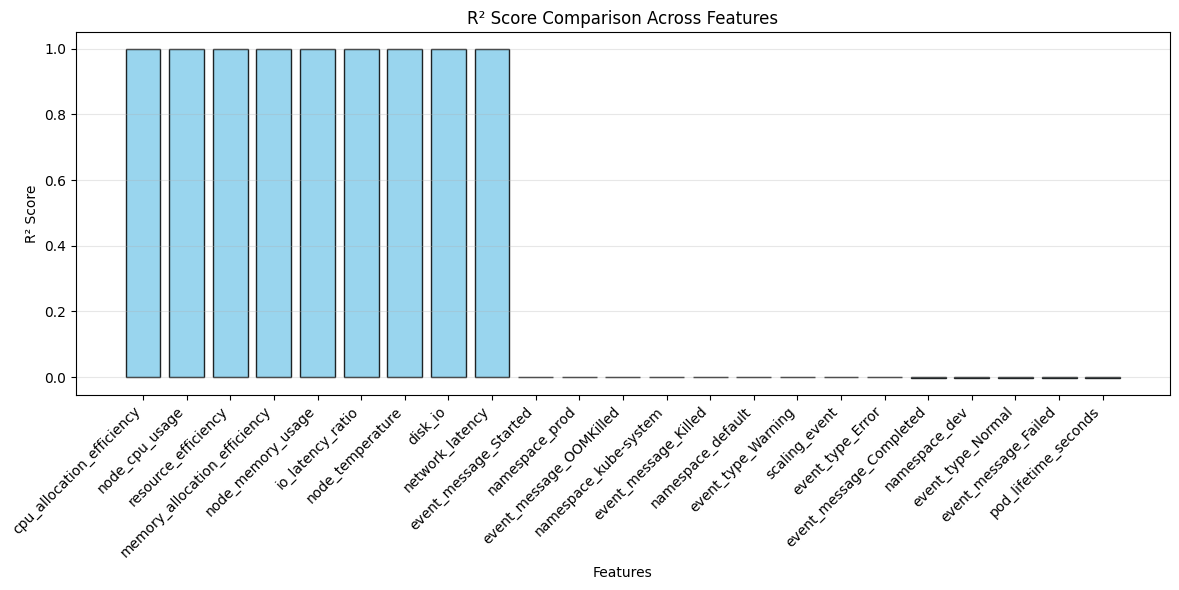

In [76]:
# Create a DataFrame for results
r2_results = pd.DataFrame({"Feature": columns_to_compare, "R² Score": r2_scores})

# Sort by R² Score
r2_results = r2_results.sort_values(by="R² Score", ascending=False)

# Plot the R² scores as a bar chart
plt.figure(figsize=(12, 6))
plt.bar(
    r2_results["Feature"],
    r2_results["R² Score"],
    color="skyblue",
    edgecolor="black",
    alpha=0.85,
)
plt.title("R² Score Comparison Across Features")
plt.xlabel("Features")
plt.ylabel("R² Score")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

### [OPTIONAL] 7.2. Applying Random Forest Regressor for Multiple Columns

In this step, we’ll use **Random Forest Regressor** to predict multiple target columns in the dataset. For each column in `columns_to_compare`, we:

1. Treat the column as the target variable.
2. Train a **Random Forest Regressor** using the numerical features as inputs.
3. Evaluate the model’s performance using:
   - **R² Score**: Measures how well the model predicts the target. Higher scores are better.
   - **Mean Absolute Error (MAE)**: Shows the average difference between predicted and actual values.
   - **Scatter Plots**: Show how close the predicted values are to the actual values.

#### How to Read the Scatter Plots

- **Close to the Red Dashed Line**: Indicates accurate predictions.
- **Far from the Red Dashed Line**: Suggests the model struggles to predict that target.

Let’s apply Random Forest to each target and visualize the results!

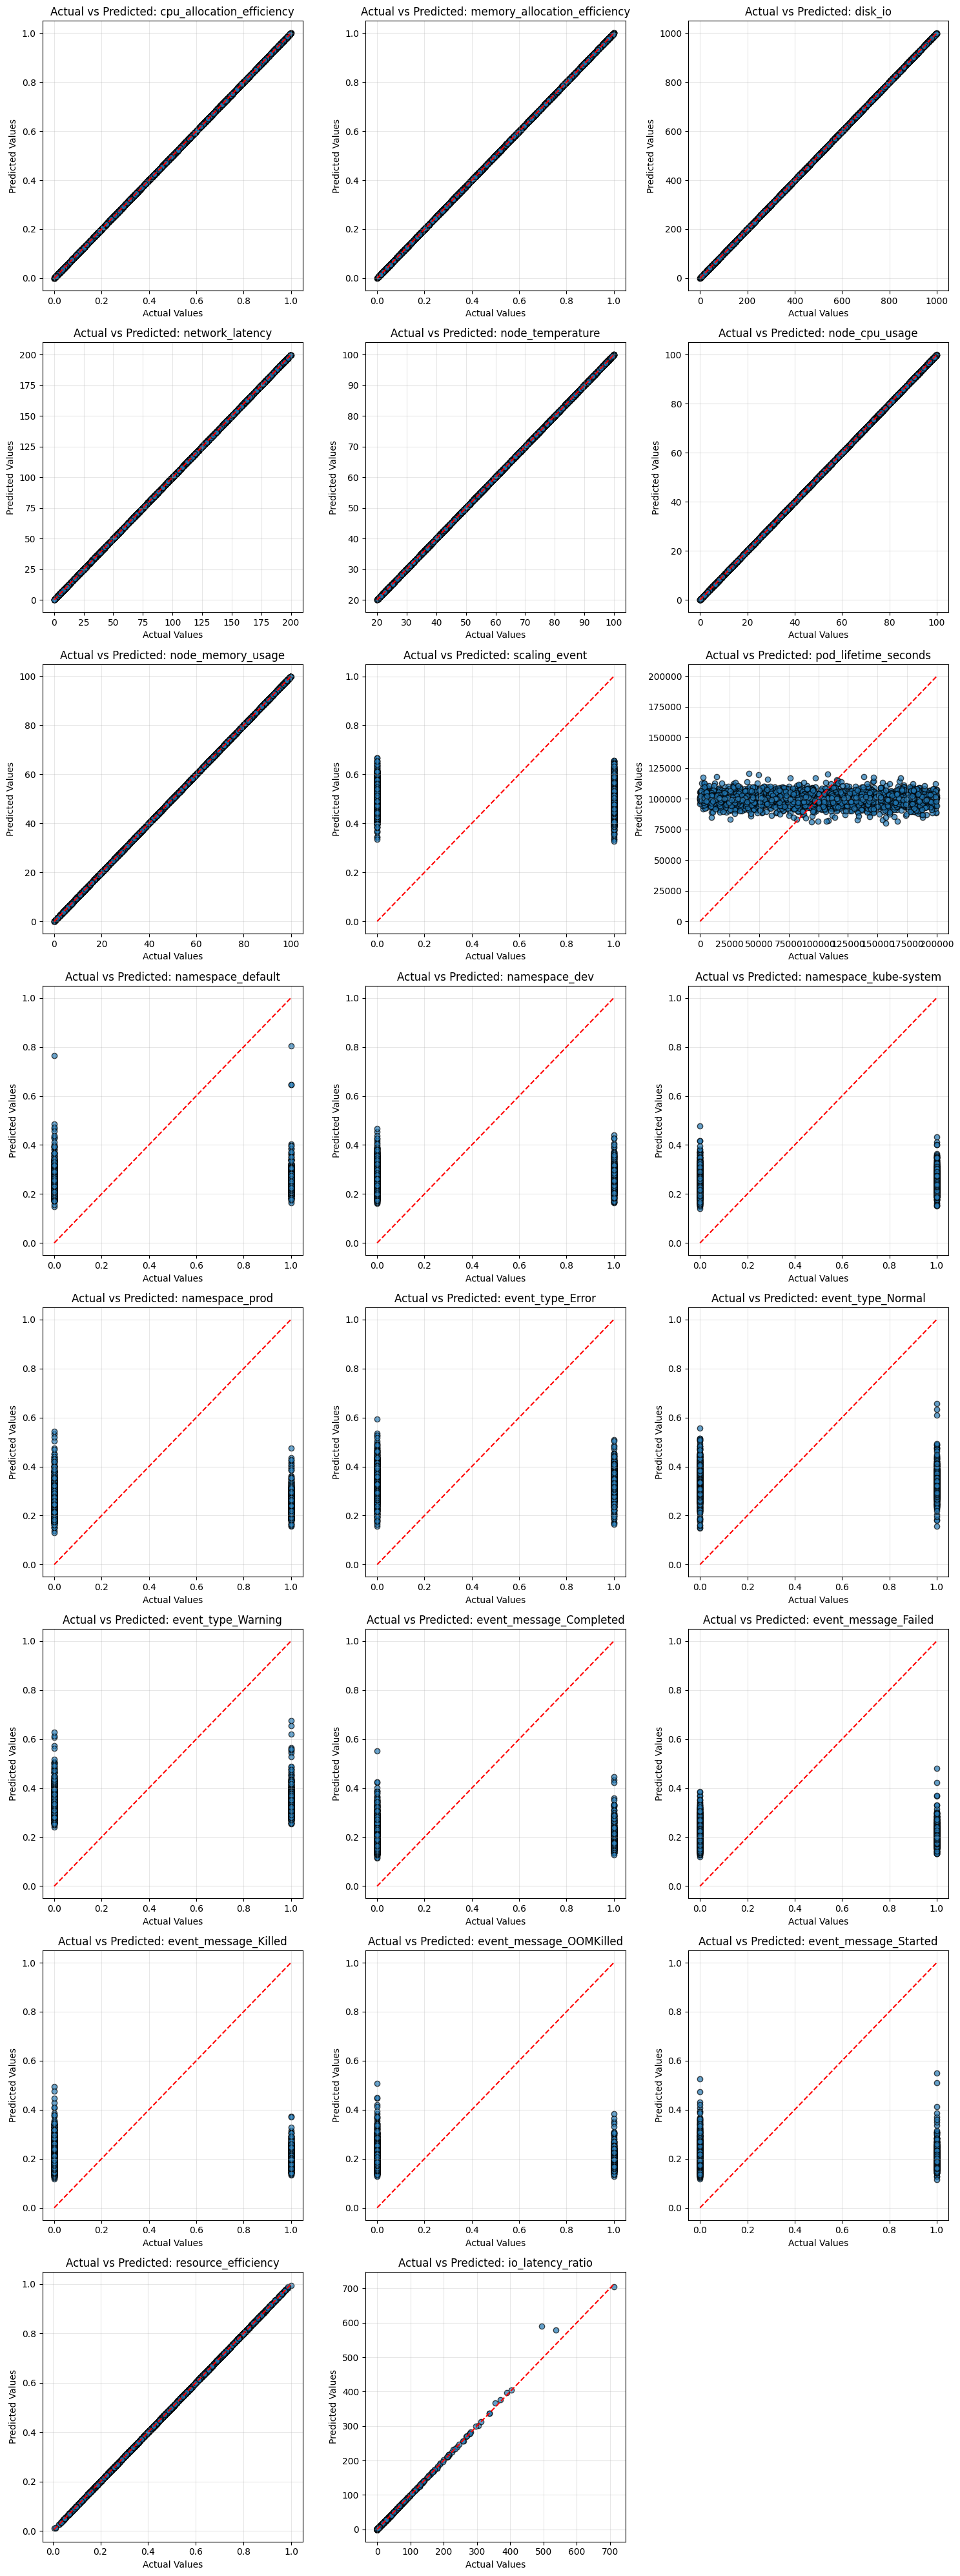

In [77]:
from sklearn.ensemble import RandomForestRegressor

# Prepare subplots
n_cols = 3  # Number of columns for subplots
n_rows = (len(columns_to_compare) + n_cols - 1) // n_cols  # Calculate rows needed
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))

# Flatten axes array for easier indexing
axes = axes.flatten()

# Store R² scores
rf_r2_scores = []
rf_mae_scores = []

# Loop through each feature and create Actual vs Predicted chart
for idx, feature in enumerate(columns_to_compare):
    # Define target and features
    target = feature
    X = df[numerical_features]  # Using all numerical features as predictors
    y = df[target]

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42
    )

    # Train Random Forest Regressor
    rf_model = RandomForestRegressor(random_state=42, n_estimators=100, max_depth=10)
    rf_model.fit(X_train, y_train)

    # Predictions
    y_pred = rf_model.predict(X_test)

    # Calculate R² score
    r2 = r2_score(y_test, y_pred)
    rf_r2_scores.append(r2)

    # MAE Score
    mae = mean_absolute_error(y_test, y_pred)
    rf_mae_scores.append(mae)

    # Plot Actual vs Predicted
    ax = axes[idx]
    ax.scatter(y_test, y_pred, alpha=0.7, edgecolor="k")
    ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--")
    ax.set_title(f"Actual vs Predicted: {feature}")
    ax.set_xlabel("Actual Values")
    ax.set_ylabel("Predicted Values")
    ax.grid(alpha=0.3)

# Remove empty subplots (if any)
for idx in range(len(columns_to_compare), len(axes)):
    fig.delaxes(axes[idx])

# Adjust layout
plt.tight_layout()
plt.show()

### Visualizing R² Scores Across Features

After applying **Random Forest** to multiple target columns, we summarize the results with an R² score comparison.

#### What Does the Chart Show?

- The bar chart ranks each feature based on its **R² score**.
- **R² Score**:
  - Measures how well the Random Forest model explains the variability of the target.
  - Higher scores indicate better predictions for that feature.
  - Lower scores suggest the model struggles to capture the relationship.

#### How to Read the Chart

- Taller bars: The model performs well for these features.
- Shorter bars: These features may need more complex models or additional preprocessing.

This visualization helps identify which features are better suited for Random Forest and where alternative methods might be needed.

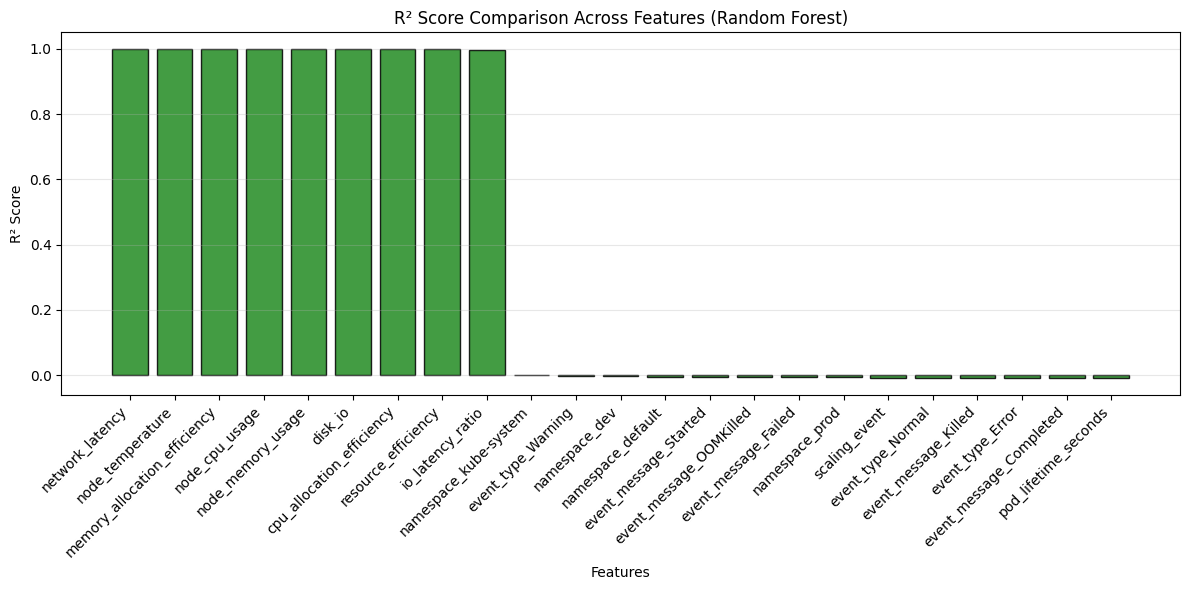

In [78]:
# Create a DataFrame for results
rf_r2_results = pd.DataFrame({"Feature": columns_to_compare, "R² Score": rf_r2_scores})

# Sort by R² Score
rf_r2_results = rf_r2_results.sort_values(by="R² Score", ascending=False)

# Plot the R² scores for Random Forest as a bar chart
plt.figure(figsize=(12, 6))
plt.bar(
    rf_r2_results["Feature"],
    rf_r2_results["R² Score"],
    color="forestgreen",
    edgecolor="black",
    alpha=0.85,
)
plt.title("R² Score Comparison Across Features (Random Forest)")
plt.xlabel("Features")
plt.ylabel("R² Score")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

## [OPTIONAL] 8. Comparing R² Scores: Linear Regression vs. Random Forest

After evaluating both **Linear Regression** and **Random Forest Regressor** for multiple target columns, let’s compare their **R² scores** for each target. This comparison will help us identify:
- Which method performs better for specific features.
- The overall effectiveness of each model across all targets.

### Steps for Comparison

1. **Combine Results**:
   - Create a DataFrame that contains the R² scores for each method (`Linear Regression` and `Random Forest`) across all target columns.

2. **Bar Chart Visualization**:
   - Plot a grouped bar chart:
     - **X-axis**: Target columns (`columns_to_compare`).
     - **Y-axis**: R² scores.
     - Two bars for each target: one for `Linear Regression` and one for `Random Forest`.

3. **Interpretation**:
   - Higher bars indicate better performance.
   - Compare which model performs better for each target.

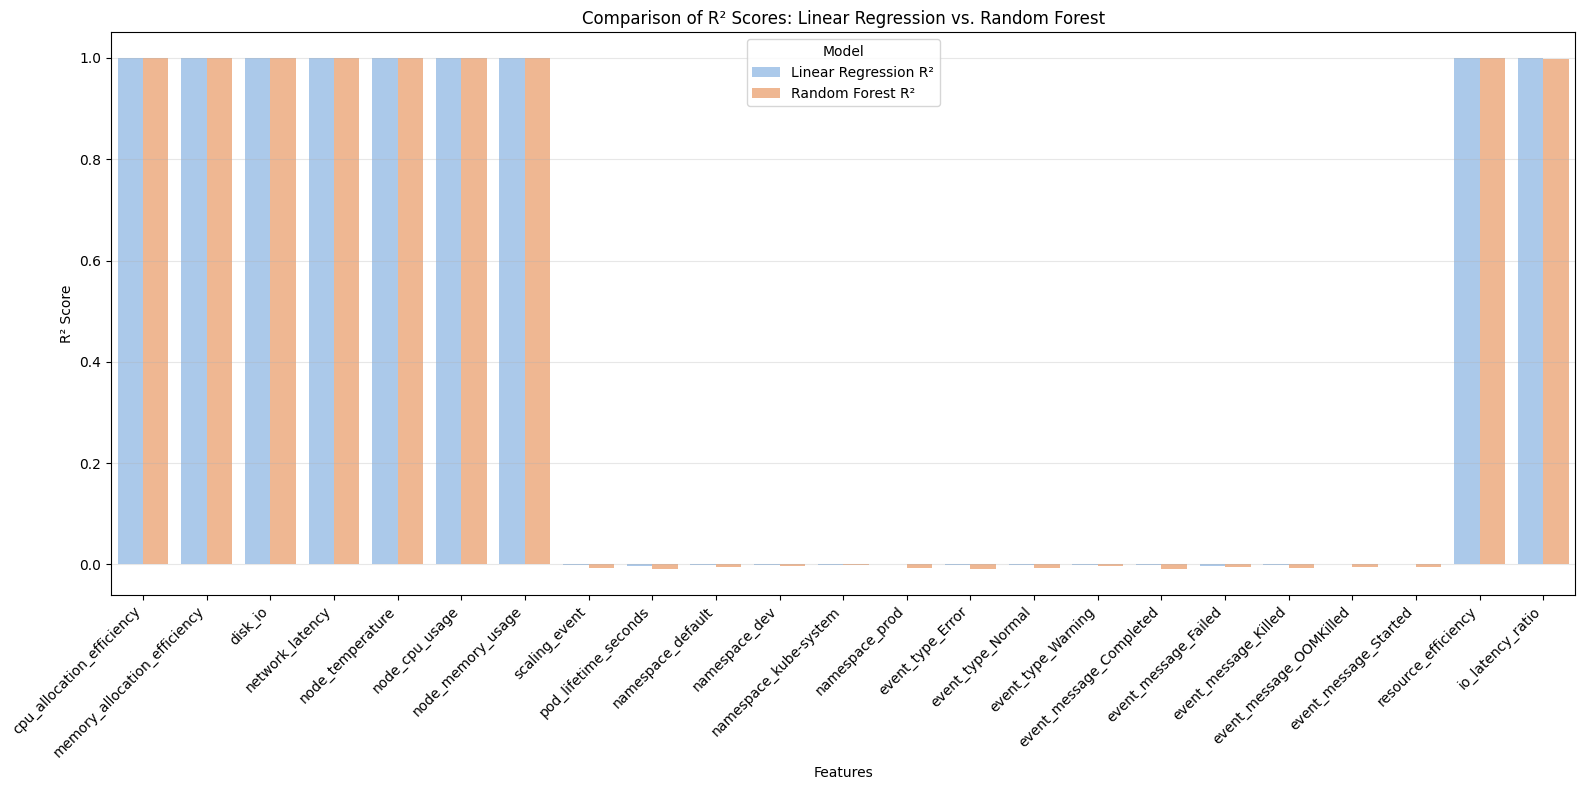

In [79]:
# Combine R² results into a DataFrame
comparison_df = pd.DataFrame(
    {
        "Feature": columns_to_compare,
        "Linear Regression R²": r2_scores,
        "Random Forest R²": rf_r2_scores,
    }
)

# Melt the DataFrame for easier plotting
comparison_melted = comparison_df.melt(
    id_vars="Feature",
    value_vars=["Linear Regression R²", "Random Forest R²"],
    var_name="Model",
    value_name="R² Score",
)

# Plot the grouped bar chart
plt.figure(figsize=(16, 8))
sns.barplot(
    x="Feature", y="R² Score", hue="Model", data=comparison_melted, palette="pastel"
)
plt.title("Comparison of R² Scores: Linear Regression vs. Random Forest")
plt.xlabel("Features")
plt.ylabel("R² Score")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Model")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

#### How to Interpret the Chart

1. **Model Performance**:
   - For each feature, compare the heights of the two bars.
   - Taller bars indicate better performance for that model on the feature.

2. **Feature-Specific Trends**:
   - Identify features where `Random Forest` significantly outperforms `Linear Regression`.
   - Look for features where both models perform poorly (low R² scores), which might indicate the need for feature engineering or a different modeling approach.

3. **Overall Trends**:
   - Assess which model is generally better across all features.